In [32]:
# first lets load the input files
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict

base_path = "./csv_files"


history = pd.read_csv(f"{base_path}/historical_data.csv")
sentiments = pd.read_csv(f"{base_path}/fear_greed_index.csv")


In [33]:
# Convert datetime columns for historical data
history['datetime'] = pd.to_datetime(history['Timestamp IST'], format='%d-%m-%Y %H:%M')
history['date'] = history['datetime'].dt.date
history['hour'] = history['datetime'].dt.hour

# Convert datetime for sentiment data
sentiments['date_parsed'] = pd.to_datetime(sentiments['date'])
sentiments['date'] = sentiments['date_parsed'].dt.date

print("✓ Datetime conversion completed")
print(f"Historical data date range: {history['date'].min()} to {history['date'].max()}")
print(f"Sentiment data date range: {sentiments['date'].min()} to {sentiments['date'].max()}")

✓ Datetime conversion completed
Historical data date range: 2023-05-01 to 2025-05-01
Sentiment data date range: 2018-02-01 to 2025-05-02


In [34]:

# the sentiment we have is only for Bitcoin 
history_full = history[history['Coin']=='BTC'].copy()
history_full['datetime'] = pd.to_datetime(history_full['Timestamp IST'], format='%d-%m-%Y %H:%M')
history_full['date'] = history_full['datetime'].dt.date

# Prepare sentiment data for full period
sentiments_full = sentiments.copy()
sentiments_full['date_parsed'] = pd.to_datetime(sentiments_full['date'])
sentiments_full['date'] = sentiments_full['date_parsed'].dt.date

# Filter sentiment data to match trading period (2023-2025)
sentiment_overlap = sentiments_full[
    (sentiments_full['date_parsed'] >= history_full['datetime'].min()) &
    (sentiments_full['date_parsed'] <= history_full['datetime'].max())
].copy()

# Create numerical mapping for sentiment
sentiment_mapping = {
    'Extreme Fear': 1,
    'Fear': 2,
    'Neutral': 3,
    'Greed': 4,
    'Extreme Greed': 5
}
sentiment_overlap['sentiment_numeric'] = sentiment_overlap['classification'].map(sentiment_mapping)


In [35]:
merged_data = history_full.merge(
    sentiment_overlap[['date', 'value', 'classification', 'sentiment_numeric']],
    on='date',
    how='left'
)

print(f"✓ Merged dataset created: {len(merged_data)} records")
print(f"Records with sentiment data: {merged_data['value'].notna().sum()}")

✓ Merged dataset created: 26064 records
Records with sentiment data: 26062


In [36]:
# Relation between Trade and Sentiment

sentiment_dist = sentiments_full['classification'].value_counts()
print(sentiment_dist)
print(f"\nAverage Fear & Greed Index: {sentiments_full['value'].mean():.1f}")

# Daily trading metrics by sentiment
daily_trading = merged_data.groupby(['date', 'classification']).agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': 'sum',
    'value': 'first'  # sentiment value
}).round(2)

daily_trading.columns = ['total_pnl', 'avg_pnl', 'trade_count', 'total_volume', 'sentiment_value']
daily_trading = daily_trading.reset_index()

# Sentiment-based performance analysis
print("\n xxxxxxx TRADING PERFORMANCE BY SENTIMENT xxxxxx")
sentiment_performance = daily_trading.groupby('classification').agg({
    'total_pnl': ['mean', 'sum', 'std'],
    'trade_count': 'mean',
    'total_volume': 'mean',
    'sentiment_value': 'mean'
}).round(2)

sentiment_performance.columns = ['avg_daily_pnl', 'total_pnl', 'pnl_volatility', 'avg_daily_trades', 'avg_daily_volume', 'avg_sentiment_value']
print(sentiment_performance)

# Calculate win rates by sentiment
sentiment_win_rates = merged_data.groupby('classification').agg({
    'Closed PnL': lambda x: (x > 0).mean()
}).round(4)
sentiment_win_rates.columns = ['win_rate']

print("\n xxxxx WIN RATES BY SENTIMENT xxxxx")
print(sentiment_win_rates)

# tradeAndSentiments(merged_data)

classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

Average Fear & Greed Index: 47.0

 xxxxxxx TRADING PERFORMANCE BY SENTIMENT xxxxxx
                avg_daily_pnl  total_pnl  pnl_volatility  avg_daily_trades  \
classification                                                               
Extreme Fear           254.74    3056.84        18813.62            147.08   
Extreme Greed         1505.71  100882.70         2246.96             36.33   
Fear                  8618.74  482649.64        19356.33            176.25   
Greed                 1121.12  115475.22         9305.08             70.29   
Neutral               3531.50  165980.37        12947.08            101.13   

                avg_daily_volume  avg_sentiment_value  
classification                                         
Extreme Fear          3062626.94                19.00  
Extreme Greed          654581.05                79.46  

Text(0.05, 0.95, 'Correlation: -0.152')

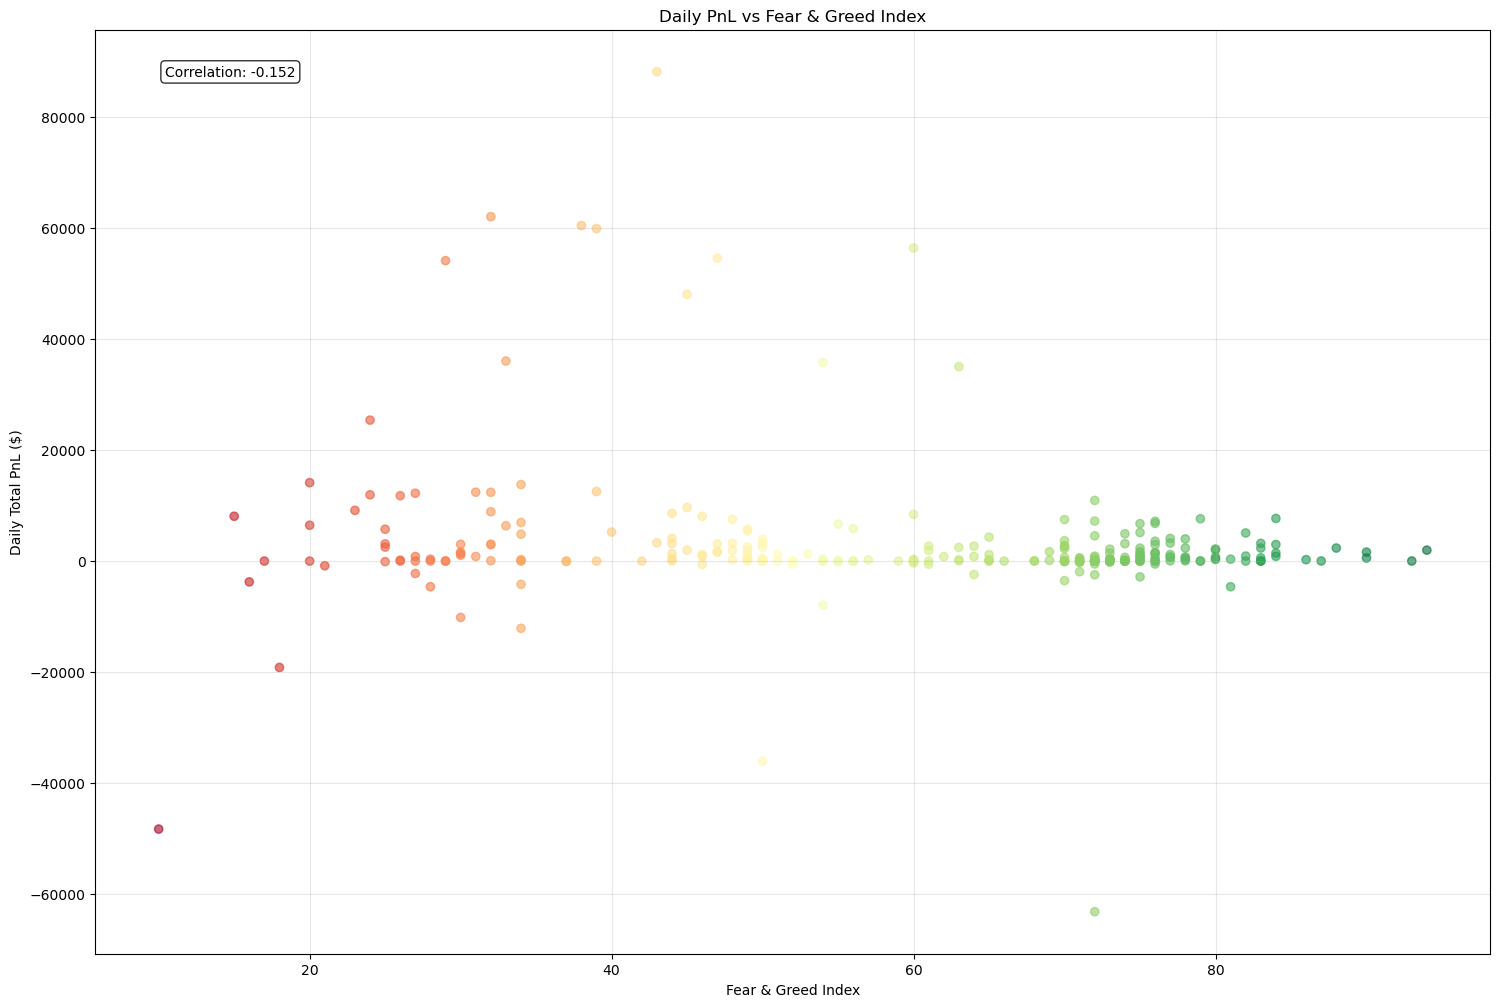

In [37]:
# Let us see how strongly they are correlated
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 12))

scatter_data = daily_trading.dropna()
scatter = ax.scatter(scatter_data['sentiment_value'], scatter_data['total_pnl'],
                     c=scatter_data['sentiment_value'], cmap='RdYlGn', alpha=0.6)

ax.set_title('Daily PnL vs Fear & Greed Index')
ax.set_xlabel('Fear & Greed Index')
ax.set_ylabel('Daily Total PnL ($)')
ax.grid(True, alpha=0.3)

correlation = scatter_data['sentiment_value'].corr(scatter_data['total_pnl'])
ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
        transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))


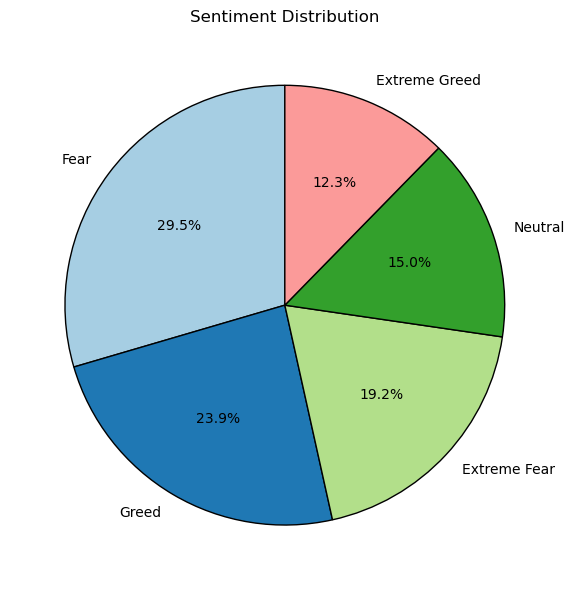

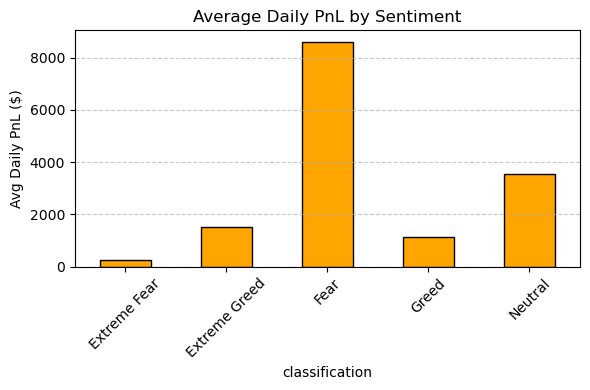

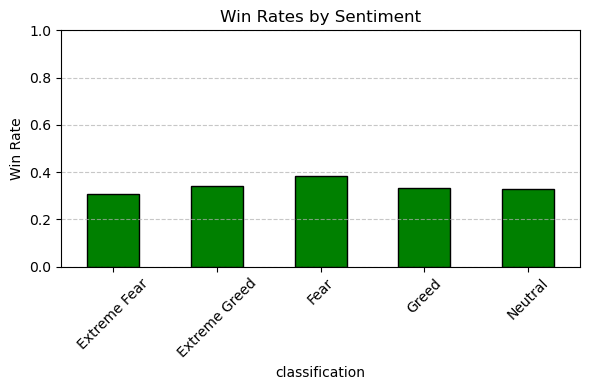

In [38]:
# --- Sentiment Distribution ---
plt.figure(figsize=(6, 6))
sentiment_dist.plot(
    kind='pie',
    autopct='%1.1f%%',  
    startangle=90,       # rotate so largest slice starts at top
    colors=plt.cm.Paired.colors,  # use paired color palette
    wedgeprops={'edgecolor': 'black'}  
)
plt.ylabel('')  
plt.title('Sentiment Distribution')
plt.tight_layout()
plt.show()

# --- Average Daily PnL by Sentiment ---
plt.figure(figsize=(6, 4))
sentiment_performance['avg_daily_pnl'].plot(kind='bar', color='orange', edgecolor='black')
plt.title('Average Daily PnL by Sentiment')
plt.ylabel('Avg Daily PnL ($)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Win Rates by Sentiment ---
plt.figure(figsize=(6, 4))
sentiment_win_rates['win_rate'].plot(kind='bar', color='green', edgecolor='black')
plt.title('Win Rates by Sentiment')
plt.ylabel('Win Rate')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # since win rates are proportions
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [39]:
# Create transition matrix

def create_transition_matrix(sequence, states):
    """Create transition probability matrix"""
    n_states = len(states)
    transitions = defaultdict(lambda: defaultdict(int))

    # Count transitions
    for i in range(len(sequence) - 1):
        current_state = sequence[i]
        next_state = sequence[i + 1]
        transitions[current_state][next_state] += 1

    # Convert to probability matrix
    transition_matrix = np.zeros((n_states, n_states))
    state_index = {state: idx for idx, state in enumerate(states)}

    for i, current_state in enumerate(states):
        total_transitions = sum(transitions[current_state].values())
        if total_transitions > 0:
            for j, next_state in enumerate(states):
                transition_matrix[i, j] = transitions[current_state][next_state] / total_transitions

    return transition_matrix, transitions

In [40]:


sentiment_dist = sentiments['classification'].value_counts()

sentiments_full = sentiments.copy()
sentiments_full['date_parsed'] = pd.to_datetime(sentiments_full['date'])
sentiments_full['date'] = sentiments_full['date_parsed'].dt.date

sentiment_2024_sorted = sentiments_full.sort_values('date_parsed')

sentiment_sequence = sentiment_2024_sorted.dropna().sort_values('date_parsed')['classification'].tolist()
states = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']



# Calculate transition matrix
transition_matrix, transition_counts = create_transition_matrix(sentiment_sequence, states)

# Display transition matrix
transition_df = pd.DataFrame(transition_matrix, index=states, columns=states)
print("📊 TRANSITION PROBABILITY MATRIX:")
print(transition_df.round(3))

# Calculate stationary distribution (long-term probabilities)
eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
stationary_idx = np.argmax(eigenvalues.real)
stationary_dist = np.abs(eigenvectors[:, stationary_idx].real)
stationary_dist = stationary_dist / stationary_dist.sum()

print("\n STATIONARY DISTRIBUTION (Long-term probabilities):")
stationary_df = pd.DataFrame({
    'State': states,
    'Long-term Probability': stationary_dist,
    'Observed Frequency': [sentiment_dist[state]/len(sentiments_full) for state in states]
}).round(4)
print(stationary_df)

# State persistence analysis
print("\n🔄 STATE PERSISTENCE ANALYSIS:")
persistence_scores = np.diag(transition_matrix)
persistence_df = pd.DataFrame({
    'State': states,
    'Self-Transition Probability': persistence_scores,
    'Expected Duration (days)': 1 / (1 - persistence_scores + 1e-10)
}).round(3)
print(persistence_df)

📊 TRANSITION PROBABILITY MATRIX:
               Extreme Fear   Fear  Neutral  Greed  Extreme Greed
Extreme Fear          0.819  0.173    0.008  0.000          0.000
Fear                  0.113  0.781    0.090  0.015          0.001
Neutral               0.008  0.172    0.641  0.179          0.000
Greed                 0.002  0.019    0.106  0.788          0.085
Extreme Greed         0.000  0.006    0.003  0.160          0.831

 STATIONARY DISTRIBUTION (Long-term probabilities):
           State  Long-term Probability  Observed Frequency
0   Extreme Fear                 0.1906              0.1921
1           Fear                 0.2929              0.2954
2        Neutral                 0.1500              0.1498
3          Greed                 0.2419              0.2394
4  Extreme Greed                 0.1247              0.1233

🔄 STATE PERSISTENCE ANALYSIS:
           State  Self-Transition Probability  Expected Duration (days)
0   Extreme Fear                        0.819          

In [41]:
# EMISSION PROBABILITIES (Hidden Markov Model Approach)
print("\n" + "\\" * 70)
print("🎯 EMISSION PROBABILITIES: Trading Performance Given Sentiment State")
print("//" * 35)

# Define performance categories as observable emissions
def categorize_performance(pnl):
    """Categorize daily PnL into performance levels"""
    if pnl > 50000:
        return 'Excellent'
    elif pnl > 10000:
        return 'Good'
    elif pnl > 0:
        return 'Positive'
    elif pnl > -10000:
        return 'Negative'
    else:
        return 'Poor'

# Calculate emission probabilities
daily_pnl_by_sentiment = daily_trading.copy()
daily_pnl_by_sentiment['performance_category'] = daily_pnl_by_sentiment['total_pnl'].apply(categorize_performance)

# Emission matrix: P(Performance | Sentiment State)
performance_states = ['Excellent', 'Good', 'Positive', 'Negative', 'Poor']
emission_matrix = np.zeros((len(states), len(performance_states)))

for i, sentiment_state in enumerate(states):
    sentiment_data = daily_pnl_by_sentiment[daily_pnl_by_sentiment['classification'] == sentiment_state]
    if len(sentiment_data) > 0:
        performance_counts = sentiment_data['performance_category'].value_counts()
        total_days = len(sentiment_data)

        for j, perf_state in enumerate(performance_states):
            emission_matrix[i, j] = performance_counts.get(perf_state, 0) / total_days

emission_df = pd.DataFrame(emission_matrix, index=states, columns=performance_states)
print(" EMISSION PROBABILITY MATRIX P(Performance | Sentiment):")
print(emission_df.round(3))

# 3. PREDICTIVE ANALYSIS USING MARKOV CHAINS
print("\n" + "\\" * 70)
print(" PREDICTIVE ANALYSIS: Future Performance Probability")
print("//" * 35)

# Function to predict next state probabilities
def predict_next_states(current_state, transition_matrix, states, n_steps=1):
    """Predict probability distribution of future states"""
    current_idx = states.index(current_state)
    current_vector = np.zeros(len(states))
    current_vector[current_idx] = 1.0

    # Matrix multiplication for n steps
    future_probs = current_vector @ np.linalg.matrix_power(transition_matrix, n_steps)
    return dict(zip(states, future_probs))

# Predict performance for each current sentiment state
print(" NEXT-DAY PREDICTIONS:")
for current_sentiment in states:
    next_day_probs = predict_next_states(current_sentiment, transition_matrix, states)

    # Expected performance based on emission probabilities
    expected_performance = 0
    performance_breakdown = {}

    for next_sentiment, prob in next_day_probs.items():
        sentiment_idx = states.index(next_sentiment)
        # Calculate expected value using emission probabilities and performance percentages
        perf_values = {'Excellent': 0.15, 'Good': 0.08, 'Positive': 0.02, 'Negative': -0.03, 'Poor': -0.10}

        for perf_category, perf_value in perf_values.items():
            perf_idx = performance_states.index(perf_category)
            expected_performance += prob * emission_matrix[sentiment_idx, perf_idx] * perf_value

            if perf_category not in performance_breakdown:
                performance_breakdown[perf_category] = 0
            performance_breakdown[perf_category] += prob * emission_matrix[sentiment_idx, perf_idx]

    print(f"\n If current state is '{current_sentiment}':")
    print(f"   Expected Return tomorrow: {expected_performance:+.2%}")
    print(f"   Most likely next state: {max(next_day_probs, key=next_day_probs.get)} ({max(next_day_probs.values()):.1%})")

    # Show top performance probabilities
    top_performances = sorted(performance_breakdown.items(), key=lambda x: x[1], reverse=True)[:2]
    print(f"   Performance probabilities: {top_performances[0][0]} ({top_performances[0][1]:.1%}), {top_performances[1][0]} ({top_performances[1][1]:.1%})")


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
🎯 EMISSION PROBABILITIES: Trading Performance Given Sentiment State
//////////////////////////////////////////////////////////////////////
 EMISSION PROBABILITY MATRIX P(Performance | Sentiment):
               Excellent   Good  Positive  Negative   Poor
Extreme Fear       0.000  0.250     0.250     0.333  0.167
Fear               0.089  0.125     0.554     0.196  0.036
Neutral            0.021  0.043     0.660     0.255  0.021
Greed              0.010  0.019     0.631     0.330  0.010
Extreme Greed      0.000  0.000     0.851     0.149  0.000

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
 PREDICTIVE ANALYSIS: Future Performance Probability
//////////////////////////////////////////////////////////////////////
 NEXT-DAY PREDICTIONS:

 If current state is 'Extreme Fear':
   Expected Return tomorrow: +0.30%
   Most likely next state: Extreme Fear (81.9%)
   Performance probabilities: Negativ


MARKOV CHAIN VISUALIZATIONS


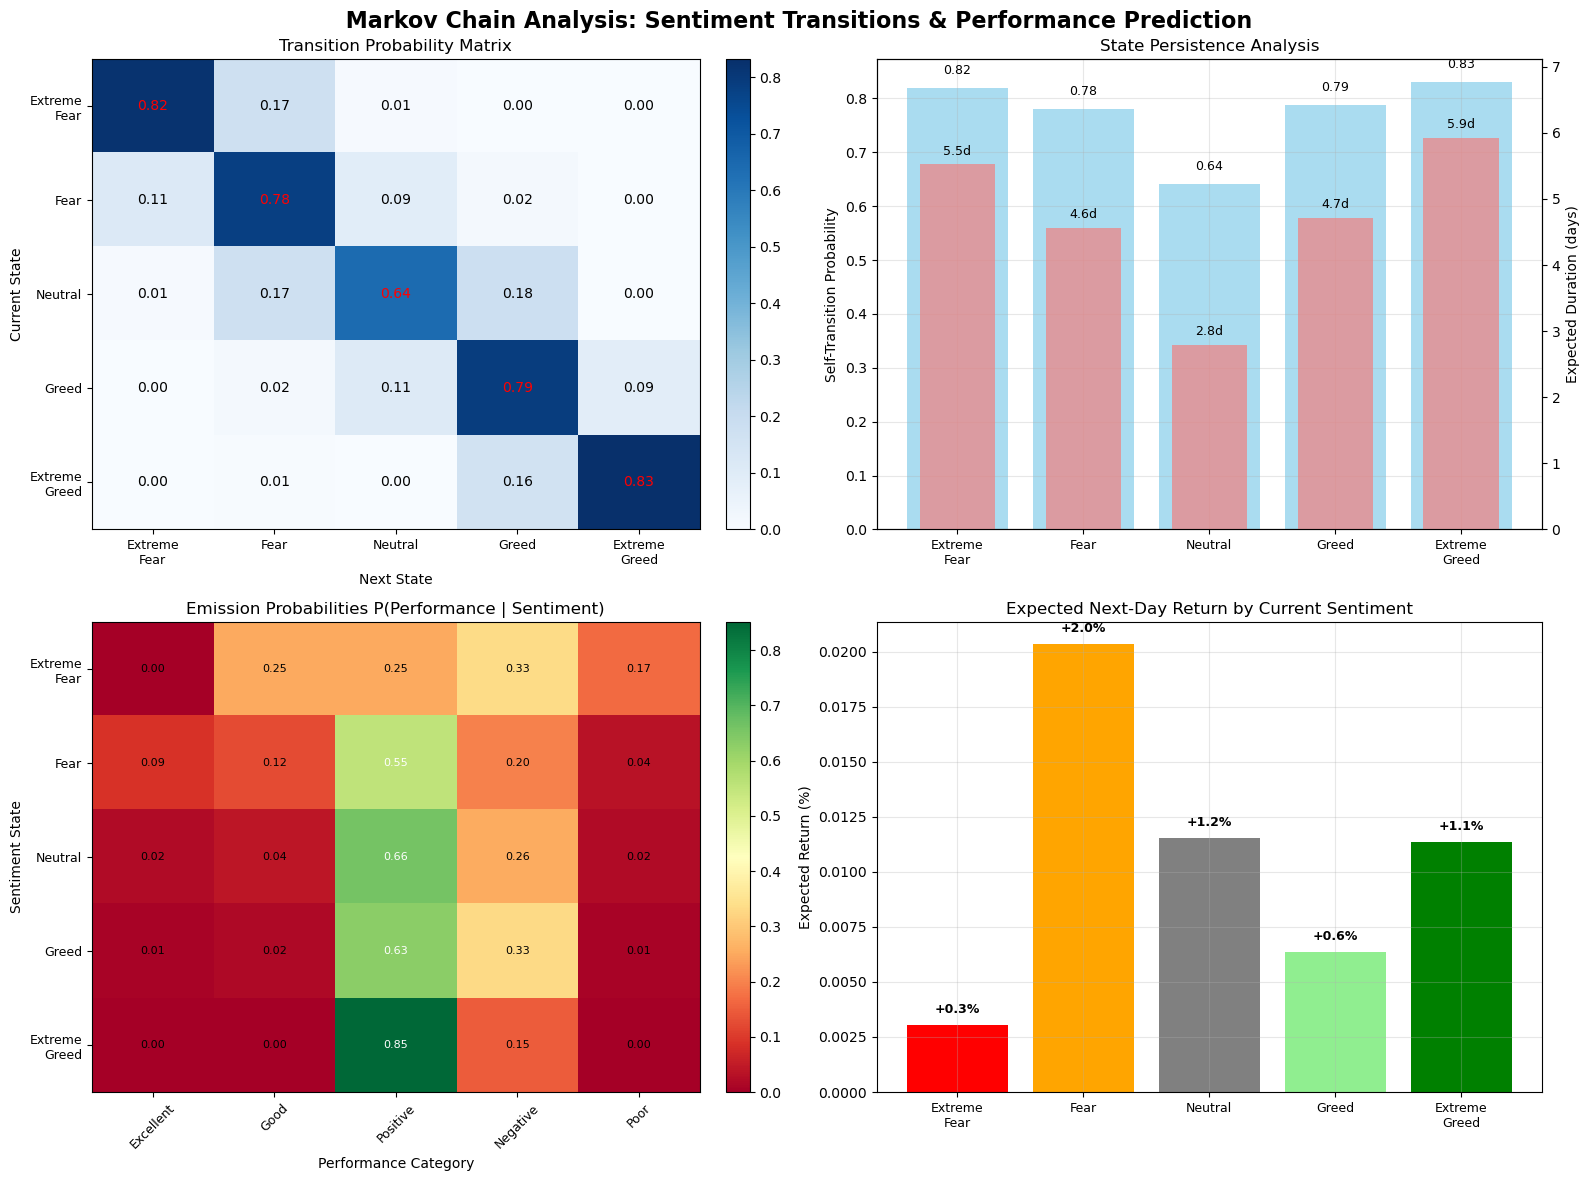


MARKET REGIME DETECTION:
REGIME PERSISTENCE STATISTICS:
               regime_count  avg_duration  duration_std  min_duration  \
regime                                                                  
Extreme Fear             92          5.55         10.16             1   
Extreme Greed            55          5.93         11.77             1   
Fear                    171          4.57          6.17             1   
Greed                   135          4.70          6.19             1   
Neutral                 142          2.79          3.75             1   

               max_duration  
regime                       
Extreme Fear             74  
Extreme Greed            77  
Fear                     48  
Greed                    42  
Neutral                  28  

🎯 KEY MARKOV CHAIN INSIGHTS:
• Most persistent state: Extreme Greed (lasts 5.9 days on average)
• Most volatile state: Neutral (lasts 2.8 days on average)
• Best predictive state for high performance: Fear
• Highest tran

In [ ]:
# MARKOV CHAIN VISUALIZATIONS AND REGIME ANALYSIS
print("\n" + "=" * 70)
print("MARKOV CHAIN VISUALIZATIONS")
print("=" * 70)

# Create comprehensive Markov Chain visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(' Markov Chain Analysis: Sentiment Transitions & Performance Prediction', fontsize=16, fontweight='bold')

# 1. Transition Matrix Heatmap
im1 = axes[0,0].imshow(transition_matrix, cmap='Blues', aspect='auto')
axes[0,0].set_xticks(range(len(states)))
axes[0,0].set_yticks(range(len(states)))
axes[0,0].set_xticklabels([s.replace(' ', '\n') for s in states], fontsize=9)
axes[0,0].set_yticklabels([s.replace(' ', '\n') for s in states], fontsize=9)
axes[0,0].set_title('Transition Probability Matrix')
axes[0,0].set_xlabel('Next State')
axes[0,0].set_ylabel('Current State')

# Add probability values to heatmap
for i in range(len(states)):
    for j in range(len(states)):
        text = axes[0,0].text(j, i, f'{transition_matrix[i, j]:.2f}',
                             ha="center", va="center", color="red" if transition_matrix[i, j] > 0.5 else "black")

plt.colorbar(im1, ax=axes[0,0], fraction=0.046, pad=0.04)

# 2. State Persistence and Expected Duration
persistence_data = persistence_df.copy()
bars1 = axes[0,1].bar(range(len(states)), persistence_data['Self-Transition Probability'],
                      color='skyblue', alpha=0.7, label='Self-Transition Prob')
axes[0,1].set_xticks(range(len(states)))
axes[0,1].set_xticklabels([s.replace(' ', '\n') for s in states], fontsize=9)
axes[0,1].set_title('State Persistence Analysis')
axes[0,1].set_ylabel('Self-Transition Probability')
axes[0,1].grid(True, alpha=0.3)

# Add duration labels
ax_twin = axes[0,1].twinx()
bars2 = ax_twin.bar(range(len(states)), persistence_data['Expected Duration (days)'],
                    color='lightcoral', alpha=0.7, width=0.6, label='Expected Duration')
ax_twin.set_ylabel('Expected Duration (days)')
ax_twin.set_ylim(0, max(persistence_data['Expected Duration (days)']) * 1.2)

# Add value labels
for i, (prob, duration) in enumerate(zip(persistence_data['Self-Transition Probability'],
                                        persistence_data['Expected Duration (days)'])):
    axes[0,1].text(i, prob + 0.02, f'{prob:.2f}', ha='center', va='bottom', fontsize=9)
    ax_twin.text(i, duration + 0.1, f'{duration:.1f}d', ha='center', va='bottom', fontsize=9)

# 3. Emission Probability Heatmap
im2 = axes[1,0].imshow(emission_matrix, cmap='RdYlGn', aspect='auto')
axes[1,0].set_xticks(range(len(performance_states)))
axes[1,0].set_yticks(range(len(states)))
axes[1,0].set_xticklabels(performance_states, fontsize=9, rotation=45)
axes[1,0].set_yticklabels([s.replace(' ', '\n') for s in states], fontsize=9)
axes[1,0].set_title('Emission Probabilities P(Performance | Sentiment)')
axes[1,0].set_xlabel('Performance Category')
axes[1,0].set_ylabel('Sentiment State')

# Add emission probability values
for i in range(len(states)):
    for j in range(len(performance_states)):
        text = axes[1,0].text(j, i, f'{emission_matrix[i, j]:.2f}',
                             ha="center", va="center",
                             color="white" if emission_matrix[i, j] > 0.5 else "black", fontsize=8)

plt.colorbar(im2, ax=axes[1,0], fraction=0.046, pad=0.04)

# 4. Expected Performance by Current State
expected_perfs = []
current_sentiment_states = []
for current_sentiment in states:
    next_day_probs = predict_next_states(current_sentiment, transition_matrix, states)
    expected_performance = 0
    perf_values = {'Excellent': 0.15, 'Good': 0.08, 'Positive': 0.02, 'Negative': -0.03, 'Poor': -0.10}

    for next_sentiment, prob in next_day_probs.items():
        sentiment_idx = states.index(next_sentiment)
        for perf_category, perf_value in perf_values.items():
            perf_idx = performance_states.index(perf_category)
            expected_performance += prob * emission_matrix[sentiment_idx, perf_idx] * perf_value

    expected_perfs.append(expected_performance)
    current_sentiment_states.append(current_sentiment.replace(' ', '\n'))

bars3 = axes[1,1].bar(range(len(states)), expected_perfs,
                      color=['red', 'orange', 'gray', 'lightgreen', 'green'])
axes[1,1].set_xticks(range(len(states)))
axes[1,1].set_xticklabels(current_sentiment_states, fontsize=9)
axes[1,1].set_title('Expected Next-Day Return by Current Sentiment')
axes[1,1].set_ylabel('Expected Return (%)')
axes[1,1].grid(True, alpha=0.3)

# Add value labels
for i, perf in enumerate(expected_perfs):
    axes[1,1].text(i, perf + (max(expected_perfs) * 0.02), f'{perf:+.1%}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# 5. MARKET REGIME DETECTION
print("\nMARKET REGIME DETECTION:")
print("=" * 40)

# Identify regime transitions (when sentiment state changes significantly)
regime_changes = []
current_regime = None
regime_start = None

for i, row in sentiment_2024_sorted.iterrows():
    sentiment_state = row['classification']

    if current_regime != sentiment_state:
        if current_regime is not None:
            regime_changes.append({
                'regime': current_regime,
                'start_date': regime_start,
                'end_date': row['date_parsed'] - pd.Timedelta(days=1),
                'duration': (row['date_parsed'] - regime_start).days
            })

        current_regime = sentiment_state
        regime_start = row['date_parsed']

# Add final regime
if current_regime and regime_start:
    regime_changes.append({
        'regime': current_regime,
        'start_date': regime_start,
        'end_date': sentiment_2024_sorted['date_parsed'].iloc[-1],
        'duration': (sentiment_2024_sorted['date_parsed'].iloc[-1] - regime_start).days + 1
    })

regime_df = pd.DataFrame(regime_changes)
regime_summary = regime_df.groupby('regime').agg({
    'duration': ['count', 'mean', 'std', 'min', 'max']
}).round(2)

regime_summary.columns = ['regime_count', 'avg_duration', 'duration_std', 'min_duration', 'max_duration']

print("REGIME PERSISTENCE STATISTICS:")
print(regime_summary)

print(f"\n KEY MARKOV CHAIN INSIGHTS:")
print(f"• Most persistent state: {persistence_df.loc[persistence_df['Expected Duration (days)'].idxmax(), 'State']} (lasts {persistence_df['Expected Duration (days)'].max():.1f} days on average)")
print(f"• Most volatile state: {persistence_df.loc[persistence_df['Expected Duration (days)'].idxmin(), 'State']} (lasts {persistence_df['Expected Duration (days)'].min():.1f} days on average)")
print(f"• Best predictive state for high performance: {states[np.argmax(expected_perfs)]}")
print(f"• Highest transition probability: {transition_matrix.max():.1%} (staying in {states[np.unravel_index(transition_matrix.argmax(), transition_matrix.shape)[0]]})")